In [1]:
%pylab nbagg
from tvb.simulator.lab import *

# Simulate cortical surface with s/M/EEG forward solutions

Cortical surface with subcortical regions, sEEG, EEG & MEG, using a stochastic
integration.

In [5]:
from tvb.datatypes.cortex import Cortex
from tvb.datatypes.region_mapping import RegionMapping
from tvb.datatypes.projections import ProjectionMatrix, ProjectionSurfaceEEG
from tvb.datatypes.sensors import SensorsEEG

oscillator = models.Generic2dOscillator(a=0.1, tau=2.0)

white_matter = connectivity.Connectivity.from_file('connectivity_192.zip')
white_matter.speed = numpy.array([4.0])
white_matter_coupling = coupling.Difference(a=0.014)

rm = RegionMapping.from_file('regionMapping_16k_192.txt')
sensorsEEG = SensorsEEG.from_file('eeg_unitvector_62.txt.bz2')
prEEG = ProjectionSurfaceEEG.from_file('projection_eeg_62_surface_16k.mat', matlab_data_name="ProjectionMatrix")

heunint = integrators.HeunStochastic(
    dt=2**-4,
    noise=noise.Additive(nsig=numpy.array([2 ** -5, ]))
)

fsamp = 1e3/1024.0 # 1024 Hz
# See shown here 3 different ways of configuring monitors.
# These methods are available for all projection monitors
mons = (
    monitors.EEG(sensors=sensorsEEG, projection=prEEG, region_mapping=rm, period=fsamp),
    monitors.MEG(load_default=True, period=fsamp),
    monitors.iEEG.from_file('seeg_588.txt', 'projection_seeg_588_surface_16k.npy', period=fsamp),
    monitors.ProgressLogger(period=100.0),
)

local_coupling_strength = numpy.array([2 ** -10])
default_cortex = Cortex(
    region_mapping_data=RegionMapping.from_file('regionMapping_16k_192.txt'),
    load_default=True)
default_cortex.coupling_strength = local_coupling_strength

sim = simulator.Simulator(
    model=oscillator,
    connectivity=white_matter,
    coupling=white_matter_coupling,
    integrator=heunint,
    monitors=mons,
    surface=default_cortex,
    simulation_length=1000.0
).configure()

eeg, meg, seeg, _ = sim.run()

<IPython.core.display.Javascript object>


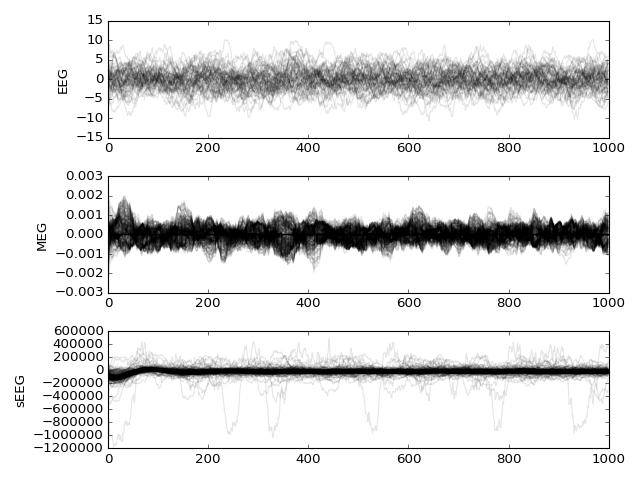

In [6]:
figure()

for i, mon in enumerate((eeg, meg, seeg)):
    subplot(3, 1, i + 1)
    time, data = mon
    plot(time, data[:, 0, :, 0], 'k', alpha=0.1)
    ylabel(['EEG', 'MEG', 'sEEG'][i])

tight_layout()